In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
test_img = "neem.jpg"

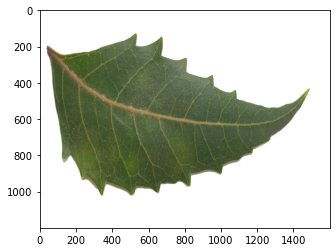

In [3]:
main_img = cv2.imread(test_img)

# CHANGING COLOR SPACE OF THE IMAGE 
 
img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

(1200, 1600)

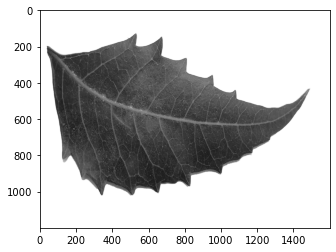

In [4]:
# CONVERTING TO GRAY SCALE
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray,cmap='Greys_r')
img_gray.shape

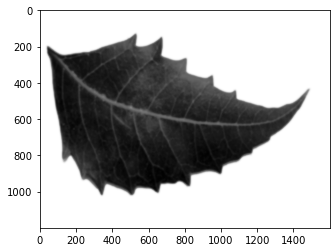

In [5]:
# SMOOTHNING OF IMAGE USING GAUSSIAN FILTER ( is used to `blur' images and remove detail and noise.)

blur = cv2.GaussianBlur(img_gray, (25,25),0)
plt.imshow(blur,cmap='Greys_r')

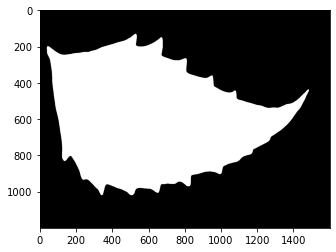

In [6]:
# APPLYING GLOBAL THRESHOLD METHOD  OTSU THRESHOLD 

ret_otsu,im_bw_otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(im_bw_otsu,cmap='Greys_r')

In [7]:
# CLOSING HOLES USING MORPHOLOGICAL TRANSFORMATION (IF ANY PRESENT)

kernel = np.ones((50,50),np.uint8)
closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)

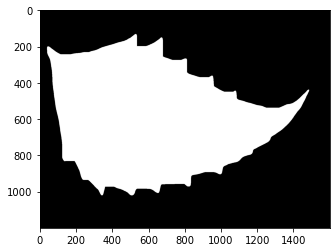

In [8]:
plt.imshow(closing,cmap='Greys_r')

# Boundary extraction

Boundary extraction is needed which will be used in calculation of shape features.

### Boundary extraction using sobel filters - Not effective

Trying to extract the boundary of the leaf using sobel filters. The image after edge extraction is thresholded using Otsu's method. Then the gaps were closed using Closing operation of Morphological Transformation.

This method is not effective as even after performing morphological transformation, gaps still persist.

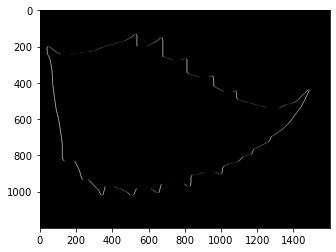

In [9]:
sobelx64f = cv2.Sobel(closing,cv2.CV_64F,1,0,ksize=5)
abs_sobel64f = np.absolute(sobelx64f)
sobel_8u = np.uint8(abs_sobel64f)
plt.imshow(abs_sobel64f,cmap='Greys_r')

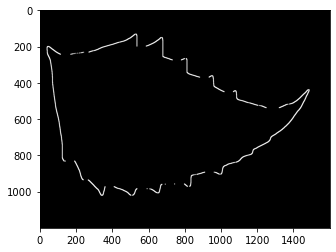

In [10]:
ret_sobel,im_bw_sobel = cv2.threshold(sobel_8u,1,255,cv2.THRESH_BINARY)
plt.imshow(im_bw_sobel,cmap='Greys_r')

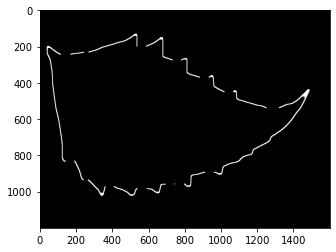

In [11]:
kernel_edge = np.ones((15,15),np.uint8)
closing_edge = cv2.morphologyEx(im_bw_sobel, cv2.MORPH_CLOSE, kernel_edge)
plt.imshow(closing_edge,cmap='Greys_r')

### Boundary extraction using contours - Effective 

Contours are used to extract leaf boundaries. They are continous, sharp and there are no gaps between the boundary pixels

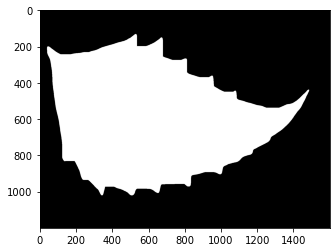

In [12]:
plt.imshow(closing,cmap="Greys_r")

In [13]:
contours, hierarchy = cv2.findContours(closing,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [14]:
len(contours)

1

In [15]:
cnt = contours[0]
len(cnt)

1664

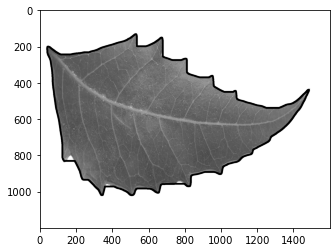

In [16]:
plottedContour = cv2.drawContours(img_gray,contours,-1,(0,255,0),10)
plt.imshow(plottedContour,cmap="Greys_r")

# MORPHOLOGICAL FEATURES

## SHAPE BASED FEATURES

### Calculate moments using contour

In [17]:
M = cv2.moments(cnt)
M

{'m00': 731724.5,
 'm10': 451746261.3333333,
 'm01': 435005178.0,
 'm20': 353102483603.25,
 'm11': 275985273293.5416,
 'm02': 287816069181.9166,
 'm30': 318483821664553.3,
 'm21': 218485915579993.4,
 'm12': 183891423128432.6,
 'm03': 205374948678610.72,
 'mu20': 74206964007.22137,
 'mu11': 7425230788.280182,
 'mu02': 29208485471.364807,
 'mu30': 8861601900691.688,
 'mu21': -599340180008.2266,
 'mu12': -2626673349245.324,
 'mu03': -458210179542.6875,
 'nu20': 0.13859560887884892,
 'nu11': 0.013868029718444226,
 'nu02': 0.05455239791158784,
 'nu30': 0.01934831923897408,
 'nu21': -0.001308592426685092,
 'nu12': -0.005735048252814983,
 'nu03': -0.001000450813712084}

In [18]:
area = cv2.contourArea(cnt)
area

731724.5

In [19]:
perimeter = cv2.arcLength(cnt,True)
perimeter

4569.72529232502

### Fitting in the best-fit rectangle and ellipse

The best-fit rectangle is chosen and not ellipse as removes (leaves out) some portion at the extreme ends of the leaf image.

C:\Users\parth\AppData\Local\Temp\ipykernel_11016\2719757872.py:3: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


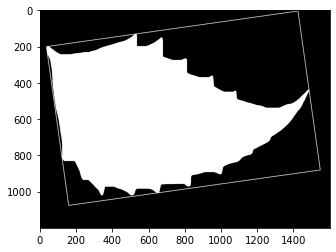

In [20]:
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
contours_im = cv2.drawContours(closing,[box],0,(255,255,255),2)
plt.imshow(contours_im,cmap="Greys_r")

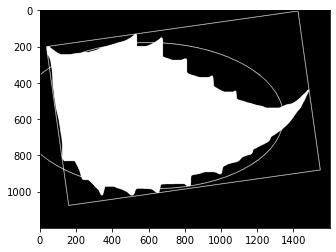

In [21]:
ellipse = cv2.fitEllipse(cnt)
im = cv2.ellipse(closing,ellipse,(255,255,255),2)
plt.imshow(closing,cmap="Greys_r")

### Shape based features calculated - Aspect ratio, rectangularity, circularity etc.

In [22]:
x,y,w,h = cv2.boundingRect(cnt)
aspect_ratio = float(w)/h
aspect_ratio

1.6283783783783783

In [23]:
rectangularity = w*h/area
rectangularity

1.7548243908738876

In [24]:
circularity = ((perimeter)**2)/area
circularity

28.538595123321674

In [25]:
equi_diameter = np.sqrt(4*area/np.pi)
equi_diameter

965.2256571660145

In [26]:
(x,y),(MA,ma),angle = cv2.fitEllipse(cnt)

## 2. Color based features

### Calculating color based features - mean, std-dev of the RGB channels

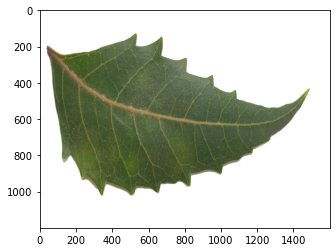

In [27]:
plt.imshow(img,cmap="Greys_r")

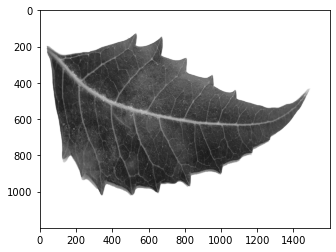

In [28]:
red_channel = img[:,:,0]
plt.imshow(red_channel,cmap="Greys_r")

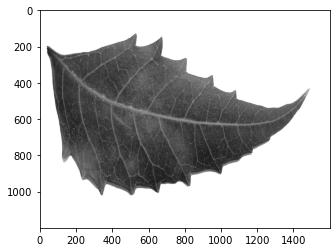

In [29]:
green_channel = img[:,:,1]
plt.imshow(green_channel,cmap="Greys_r")

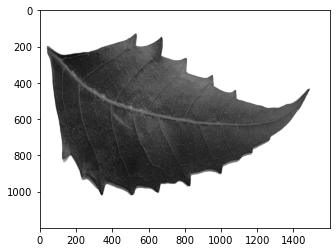

In [30]:
blue_channel = img[:,:,2]
plt.imshow(blue_channel,cmap="Greys_r")

In [31]:
np.mean(blue_channel)

180.548725

In [32]:
blue_channel[blue_channel == 255] = 0
green_channel[green_channel == 255] = 0
red_channel[red_channel == 255] = 0

In [33]:
red_mean = np.mean(red_channel)
red_mean

34.46121822916667

In [34]:
green_mean = np.mean(green_channel)
green_mean

39.818497916666665

In [35]:
blue_mean = np.mean(blue_channel)
blue_mean

25.7994515625

In [36]:
red_var = np.std(red_channel)
red_var

47.19776935865274

## 3. Texture based features 

### Using Haralick moments - calculating texture based features such as contrast, correlation, entropy

In [37]:
import mahotas as mt

In [38]:
textures = mt.features.haralick(img_gray)
#mahotas.features.haralick(img)
ht_mean = textures.mean(axis=0)
ht_mean


array([ 3.59510780e-01,  1.58819604e+02,  9.89583677e-01,  7.62336155e+03,
        7.16735550e-01,  3.71695538e+02,  3.03346266e+04,  3.72130907e+00,
        5.10476288e+00,  1.74785130e-03,  2.23790769e+00, -4.66132888e-01,
        9.77061487e-01])

In [39]:
print(ht_mean[1]) #contrast
print(ht_mean[2]) #correlation
print(ht_mean[4]) #inverse difference moments
print(ht_mean[8]) #entropy

158.81960379665026
0.9895836768288542
0.716735550429918
5.104762877692265
